In [18]:
pip install transformers==3


  Using cached transformers-3.0.0-py3-none-any.whl (754 kB)
  Using cached tokenizers-0.8.0rc4.tar.gz (96 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build tokenizers


  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      C:\Users\hp\AppData\Local\Temp\pip-build-env-vtnqm1bs\overlay\Lib\site-packages\setuptools\dist.py:314: InformationOnly: Normalizing '0.8.0.rc4' to '0.8.0rc4'
        self.metadata.version = self._normalize_version(
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-39
      creating build\lib.win-amd64-cpython-39\tokenizers
      copying tokenizers\__init__.py -> build\lib.win-amd64-cpython-39\tokenizers
      creating build\lib.win-amd64-cpython-39\tokenizers\models
      copying tokenizers\models\__init__.py -> build\lib.win-amd64-cpython-39\tokenizers\models
      creating build\lib.win-amd64-cpython-39\tokenizers\decoders
      copying tokenizers\decoders\__init__.py -> build\lib.win-amd64-cpython-39\tokenizers\decoders
      creating 

In [16]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt

In [2]:


# Replace smart quotes with regular double quotes
df = pd.read_excel("bert_nlp_data_main1.xlsx")
df.head()


,Sentence,Label
0,What would you like to order in Barbecue?,food_order.type.food
1,"Yeah, I'd like to get a rack of ribs.",food_order.name.item
2,"With rack of ribs, I would suggest Barbecue sa...",food_order.name.item
3,"With rack of ribs, I would suggest Barbecue sa...",food_order.name.item
4,"Yeah. Of course, I want the barbecue sauce and...",food_order.name.item


In [3]:
df['Label'].value_counts()

Label
food_order.name.item                 6022
food_order.other_description.item    1453
food_order.type.food                 1224
food_order.time.pickup               1045
food_order.num.people                 856
Name: count, dtype: int64

In [4]:
# Converting the labels into encodings
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
# check class distribution
df['Label'].value_counts(normalize = True)

Label
0    0.568113
2    0.137075
4    0.115472
3    0.098585
1    0.080755
Name: proportion, dtype: float64

In [5]:
train_text, train_labels = df['Sentence'], df['Label']

In [6]:
from transformers import DistilBertTokenizer, DistilBertModel
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
text = ["this is a distil bert model.","data is oil"]
# Encode the text
encoded_input = tokenizer(text, padding=True,truncation=True, return_tensors='pt')
print(encoded_input)
'''In input_ids:
101 - Indicates beginning of the sentence
102 - Indicates end of the sentence
In attention_mask:
1 - Actual token
0 - Padded token'''


{'input_ids': tensor([[  101,  2023,  2003,  1037,  4487, 16643,  2140, 14324,  2944,  1012,
           102],
        [  101,  2951,  2003,  3514,   102,     0,     0,     0,     0,     0,
             0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}


'In input_ids:\n101 - Indicates beginning of the sentence\n102 - Indicates end of the sentence\nIn attention_mask:\n1 - Actual token\n0 - Padded token'

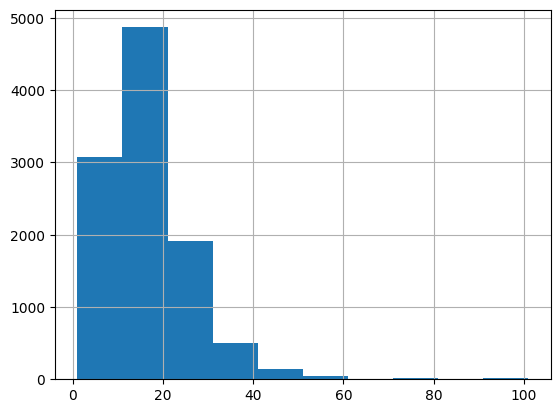

In [8]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)
# Based on the histogram we are selecting the max len as 50
max_seq_len = 50

In [9]:
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

In [10]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [12]:
class BERT_Arch(nn.Module):
   def __init__(self, bert):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,5)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)
      return x

In [13]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Arch(bert)
# push the model to GPU
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           1,285
├─LogSoftmax: 1-7                                       --
Total 

In [19]:
from transformers import AdamW
# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

RuntimeError: Failed to import transformers.optimization because of the following error (look up to see its traceback):
Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [20]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
print(class_wts)



[0.35204251 2.47663551 1.45905024 2.02870813 1.73202614]


In [21]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
# loss function
cross_entropy = nn.NLLLoss(weight=weights)

In [22]:
# empty lists to store training and validation loss of each epoch
train_losses=[]
# number of training epochs
epochs = 7


In [23]:
# function to train the model
def train():
    model.train()
    total_loss = 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        sent_id, mask, labels = batch
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # clear calculated gradients
        optimizer.zero_grad()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in the form of (number of samples, no. of classes)
    total_preds = np.concatenate([p.detach().numpy() for p in total_preds], axis=0)

    
    # return the loss and predictions
    return avg_loss, total_preds


In [ ]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f'\nTraining Loss: {train_loss:.3f}')

In [25]:
import json

# Load intents from JSON file
with open('intents.json', 'r') as file:
    intents = json.load(file)["intents"]

def get_prediction(str):
    str = re.sub(r'[^a-zA-Z ]+', '', str)
    test_text = [str]
    model.eval()
 
    tokens_test_data = tokenizer(
        test_text,
        max_length=max_seq_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    test_mask = torch.tensor(tokens_test_data['attention_mask'])
    device = torch.device("cpu")

    preds = None
    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
    preds = np.argmax(preds, axis=1)
    print("Intent Identified: ", le.inverse_transform(preds)[0])
    return le.inverse_transform(preds)[0]

def get_response(input_message):
    intent_tag = get_prediction(input_message)
    
    # Find the intent in the intents list
    matched_intent = next((i for i in intents if i["tag"] == intent_tag), None)
    
    if matched_intent:
        responses = matched_intent["responses"]
        result = random.choice(responses)
        print(f"Response: {result}")
       # return "Intent: " + intent_tag + '\n' + "Response: " + result
    else:
        print("Intent not found in intents list")
        return "Intent not found"

# Example usage
get_response("Hi, I would like to order food for takeout for three people. I want to order sandwiches. I like to order Po' Boy sandwich, pastrami on rye sandwich, a french cheese steak sandwic")


Intent Identified:  food_order.name.item
Response: Thanks that will be $30


In [26]:
import pickle
# Assuming 'model' is your trained machine learning model
with open('model1.pickle', 'wb') as file:
    pickle.dump(model, file)


In [27]:
file.close()
